## Liberaries

In [1]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Loading the dataset

In [2]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', header=None, encoding='latin')

df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Preprocessing & Data Cleaning

1. Rename the required columns

In [3]:
df.rename(columns={
    0:'Sentiment',
    5:'Tweets'
}, inplace=True)

df.head()

,Sentiment,1,2,3,4,Tweets
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


2. Remove unnessery columns

In [4]:
df.drop([1,2,3,4], axis=1, inplace=True)

df.head()

,Sentiment,Tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


3. Replace 4 with 1 that reflects Positive sentiment

In [5]:
df['Sentiment'].unique()

array([0, 4], dtype=int64)

In [6]:
df['Sentiment'][df['Sentiment'] == 4] = 1

df['Sentiment'].unique()

array([0, 1], dtype=int64)

4. Getting a portion of the dataset as the whole dataset is huge

In [7]:
df = df.sample(frac=1).reset_index(drop=True)

df = df[:10000]

df.head()

,Sentiment,Tweets
0,0,Wants to go home... bored of work now
1,0,@jeffLmsu good call on holding for take 3........
2,1,just watched the new moon trailer aa i love it
3,0,Should I go check what it iss????
4,1,the mammaaaaa &amp; sister. http://twitpic.co...


In [8]:
df.shape

(10000, 2)

In [9]:
df['Sentiment'].value_counts()

Sentiment
1    5089
0    4911
Name: count, dtype: int64

5. Data Cleaning ***

In [10]:
tweets = df['Tweets'].values

tweets

array(['Wants to go home... bored of work now ',
       '@jeffLmsu good call on holding for take 3..... cause take 1 was a *huge* failure ',
       'just watched the new moon trailer aa i love it ', ...,
       'gettin thangs together so we can head to SAN ANTONIO... i wish i was goin to a spurs game  lol its all good...',
       "it's evening !! Traffic jam ",
       'talk to me peoples  hows everybody today ?'], dtype=object)

In [11]:
cleaned_tweets = []
lemmatization = WordNetLemmatizer()

for tweet in tqdm(tweets):
    # convert into lower case
    tweet = tweet.lower()
    # remove links
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
    # remove @
    tweet = re.sub(r'@\S+', '', tweet)
    # remove special characters
    tweet = re.sub(r'[^\w\s#]', '', tweet)
    # lemmatize each word
    tweet = [lemmatization.lemmatize(word) for word in word_tokenize(tweet)]
    # remove stop words
    tweet = [word for word in tweet if word not in stopwords.words('english')]

    # processed tweet
    processed_tweet = ' '.join(tweet)

    cleaned_tweets.append(processed_tweet)

cleaned_tweets[:50]

100%|██████████| 10000/10000 [00:18<00:00, 533.38it/s]


['want go home bored work',
 'good call holding take 3 cause take 1 wa huge failure',
 'watched new moon trailer aa love',
 'go check',
 'mammaaaaa amp sister',
 'oh ouchie back maybe reason woke',
 'lol best friend im assuming mean snooter great pic way',
 'favicon ripoff smashing magazine ltgt see similarity',
 'didnt topic im trying branch amp relationship stuff',
 'life gt life',
 'yes',
 'pervs twitter dont say oh pervs would assume freudian',
 'nooo im loosin follower aweee',
 'car wiff danny going 209',
 'congratulation finally',
 'temporary happiness',
 'great get together dgbians',
 'theyre still young wait year theyre playing prank first asleep playing musicgames night',
 'glad two day five straight tho goodbye weekend',
 'reading eip really must taken alot first time around',
 'put good show politics show missed known wa would watched',
 'friend xx',
 'hum happened wheres sun',
 'scary',
 'true tiredness worry guess hope get rest today keeping optimistic key eight # capital'

6. Add two new columns

In [12]:
def word_count(text):
    return len(text.split())

def character_count(text):
    return len(text)

df['Cleaned_Tweets'] = cleaned_tweets
df['Word_Count'] = df['Cleaned_Tweets'].apply(word_count)
df['Character_Count'] = df['Cleaned_Tweets'].apply(character_count)

df.head()

,Sentiment,Tweets,Cleaned_Tweets,Word_Count,Character_Count
0,0,Wants to go home... bored of work now,want go home bored work,5,23
1,0,@jeffLmsu good call on holding for take 3........,good call holding take 3 cause take 1 wa huge ...,11,53
2,1,just watched the new moon trailer aa i love it,watched new moon trailer aa love,6,32
3,0,Should I go check what it iss????,go check,2,8
4,1,the mammaaaaa &amp; sister. http://twitpic.co...,mammaaaaa amp sister,3,20


In [13]:
df.to_csv('cleaned_data.csv',index=False)

## Creation of Word Cloud

In [13]:
positive_sentiment = df[df['Sentiment']==1].shape[0]
negative_sentiment = df[df['Sentiment']==0].shape[0]

fig = px.pie(values=[positive_sentiment, negative_sentiment],
             names=['Positive Sentiment','Negative Sentiment'],
             hover_name=['Positive Sentiment','Negative Sentiment'],
             opacity=0.8,
             template='simple_white',
             title='Distribution of Sentiments')

fig.show()

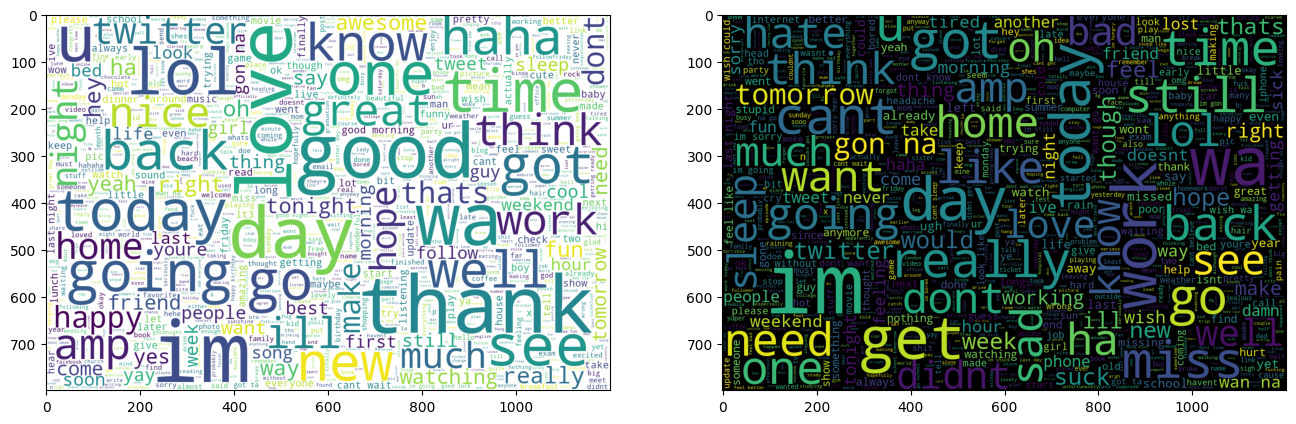

In [14]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
cloud_1 = WordCloud(width=1200, height=800, max_words=1000, contour_width=2,
    background_color='white', max_font_size=180,colormap='viridis').generate(' '.join(df[df['Sentiment']==1]['Cleaned_Tweets']))
plt.imshow(cloud_1)

plt.subplot(1,2,2)
cloud_2 = WordCloud(width=1200, height=800, max_words=1000, contour_width=2,
    background_color='black',stopwords=['good'], max_font_size=180,colormap='viridis').generate(' '.join(df[df['Sentiment']==0]['Cleaned_Tweets']))

plt.imshow(cloud_2)

In [15]:
# Create distribution plots for word count and character count for positive and negative tweets
fig_words = ff.create_distplot(
    [df[df['Sentiment'] == 1]['Word_Count'], df[df['Sentiment'] == 0]['Word_Count']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

fig_chars = ff.create_distplot(
    [df[df['Sentiment'] == 1]['Character_Count'], df[df['Sentiment'] == 0]['Character_Count']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

# Set titles and labels for the distribution plots
fig_chars.update_layout(title="Distribution Plot on Character Count", xaxis_title="Number of Characters", yaxis_title="Frequency")
fig_words.update_layout(title="Distribution Plot on Word Count", xaxis_title="Number of Words", yaxis_title="Frequency")

# Combine the plots in a 2-column layout
fig = make_subplots(rows=1, cols=2, subplot_titles=["Word Count", "Character Count"])
fig.add_trace(fig_words['data'][0], row=1, col=1)
fig.add_trace(fig_words['data'][1], row=1, col=1)
fig.add_trace(fig_chars['data'][0], row=1, col=2)
fig.add_trace(fig_chars['data'][1], row=1, col=2)

# Update overall layout and show the plot
fig.update_layout(title_text="Distribution Plots - Word Count vs Character Count", showlegend=True, font=dict(family="Arial", size=15, color="black"))
fig.show()

## Spliting of data

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df['Cleaned_Tweets'],df['Sentiment'],test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(y_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(8000,) (8000,)
(1000,) (1000,)
(1000,) (1000,)


In [17]:
fig = px.pie(values=[x_train.shape[0], x_test.shape[0], x_val.shape[0]],
        names=['Train Data','Test Data','Validate Data'],
        hover_name=['Train Data','Test Data','Validate Data'],
        title="Spliting of data",
        opacity=0.9,
        template='simple_white')

fig.show()

## <font color = "Green">Model Creation</font>

In [18]:
def sigmoid_function(values):
    ans = []
    
    for val in values:
        ans.append(1 if val >= 0.5 else 0)

    return ans

In [19]:
e_pochs = 10
batch_size = 64

1. One hot Encoding (Basic)

In [20]:
one_hot = CountVectorizer(binary=True)

one_hot.fit(df['Cleaned_Tweets'])

enc_tweets = one_hot.transform(df['Cleaned_Tweets']).toarray()

enc_tweets

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [21]:
enc_tweets.shape

(10000, 13622)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['Sentiment'], test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(8000, 13622) (8000,)
(1000, 13622) (1000,)
(1000, 13622) (1000,)


In [23]:
# choosing type of model
model = Sequential()

# input layer
model.add(Dense(2048, activation = 'relu', input_shape = (enc_tweets.shape[1],)))

# hidden layer
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(1, activation = 'sigmoid'))

# compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

# printing model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              27899904  
                                                                 
 dense_1 (Dense)             (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                

In [24]:
# model train
model.fit(x_train, y_train, epochs=e_pochs, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/10


125/125 [==============================] - 46s 336ms/step - loss: 0.6903 - accuracy: 0.5328 - val_loss: 0.6829 - val_accuracy: 0.5440
Epoch 2/10
125/125 [==============================] - 35s 280ms/step - loss: 0.6569 - accuracy: 0.6385 - val_loss: 0.5883 - val_accuracy: 0.7490
Epoch 3/10
125/125 [==============================] - 35s 279ms/step - loss: 0.5017 - accuracy: 0.7979 - val_loss: 0.4855 - val_accuracy: 0.7800
Epoch 4/10
125/125 [==============================] - 35s 276ms/step - loss: 0.2774 - accuracy: 0.9086 - val_loss: 0.5512 - val_accuracy: 0.7600
Epoch 5/10
125/125 [==============================] - 34s 275ms/step - loss: 0.1395 - accuracy: 0.9599 - val_loss: 0.7125 - val_accuracy: 0.7520
Epoch 6/10
125/125 [==============================] - 34s 274ms/step - loss: 0.0783 - accuracy: 0.9806 - val_loss: 0.8554 - val_accuracy: 0.7400
Epoch 7/10
125/125 [==============================] - 35s 276ms/step - loss: 0.0474 - accuracy: 0.9880 - val_loss: 0.9917 - val_

In [25]:
# model test
y_pred = model.predict(x_test)

print("Predicted values :",sigmoid_function(y_pred))
print("Actual values :",y_test.values)

# model accuracy
print("Model evaluation on testing data :",round(model.evaluate(x_test, y_test)[1]*100, 2),"%")

32/32 [==============================] - 1s 17ms/step
Predicted values : [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,

2. Count Vectorizer (Basic)

In [26]:
count_vec = CountVectorizer(binary=False)
count_vec.fit(df['Cleaned_Tweets'])

enc_tweets = count_vec.transform(df['Cleaned_Tweets']).toarray()

enc_tweets

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(enc_tweets,df['Sentiment'],test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test,test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(8000, 13622) (8000,)
(1000, 13622) (1000,)
(1000, 13622) (1000,)


In [28]:
model = Sequential()

model.add(Dense(2048, activation = 'relu', input_shape = (enc_tweets.shape[1],)))

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 2048)              27899904  
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [29]:
model.fit(x_train, y_train, epochs=e_pochs, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/10
125/125 [==============================] - 36s 278ms/step - loss: 0.6896 - accuracy: 0.5297 - val_loss: 0.6825 - val_accuracy: 0.5140
Epoch 2/10
125/125 [==============================] - 34s 272ms/step - loss: 0.6502 - accuracy: 0.6576 - val_loss: 0.5722 - val_accuracy: 0.7610
Epoch 3/10
125/125 [==============================] - 34s 273ms/step - loss: 0.4801 - accuracy: 0.8080 - val_loss: 0.4937 - val_accuracy: 0.7810
Epoch 4/10
125/125 [==============================] - 34s 272ms/step - loss: 0.2667 - accuracy: 0.9179 - val_loss: 0.5734 - val_accuracy: 0.7580
Epoch 5/10
125/125 [==============================] - 34s 273ms/step - loss: 0.1424 - accuracy: 0.9622 - val_loss: 0.6965 - val_accuracy: 0.7460
Epoch 6/10
125/125 [==============================] - 36s 284ms/step - loss: 0.0729 - accuracy: 0.9815 - val_loss: 0.8837 - val_accuracy: 0.7270
Epoch 7/10
125/125 [==============================] - 36s 286ms/step - loss: 0.0467 - accuracy: 0.9880 - val_loss: 1.0189 - val_ac

In [30]:
y_pred = sigmoid_function(model.predict(x_test))
print("Predicted data :",y_pred)
print("Actual data :",y_test.values)

print("Accuracy :",round(model.evaluate(x_test, y_test)[1]*100, 2),"%")

32/32 [==============================] - 1s 18ms/step
Predicted data : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1

3. TF-IDF Vectorizer (Basic)

In [31]:
tfidf = TfidfVectorizer()

enc_tweets = tfidf.fit_transform(df['Cleaned_Tweets']).toarray()

enc_tweets

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
x_train, x_test, y_train, y_test = train_test_split(enc_tweets,df['Sentiment'],test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test,test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(8000, 13622) (8000,)
(1000, 13622) (1000,)
(1000, 13622) (1000,)


In [ ]:
model = Sequential()

model.add(Dense(2048, activation = 'relu', input_shape = (enc_tweets.shape[1],)))

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

In [ ]:
model.fit(x_train, y_train, epochs=e_pochs, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/10
125/125 [==============================] - 43s 334ms/step - loss: 0.6930 - accuracy: 0.5091 - val_loss: 0.6914 - val_accuracy: 0.6380
Epoch 2/10
125/125 [==============================] - 40s 321ms/step - loss: 0.6809 - accuracy: 0.6011 - val_loss: 0.6583 - val_accuracy: 0.7000
Epoch 3/10
125/125 [==============================] - 40s 320ms/step - loss: 0.5380 - accuracy: 0.7804 - val_loss: 0.5725 - val_accuracy: 0.7130
Epoch 4/10
125/125 [==============================] - 40s 321ms/step - loss: 0.2787 - accuracy: 0.9122 - val_loss: 0.6504 - val_accuracy: 0.7030
Epoch 5/10
125/125 [==============================] - 40s 321ms/step - loss: 0.1279 - accuracy: 0.9661 - val_loss: 0.8248 - val_accuracy: 0.6860
Epoch 6/10
125/125 [==============================] - 40s 318ms/step - loss: 0.0706 - accuracy: 0.9815 - val_loss: 0.9403 - val_accuracy: 0.7000
Epoch 7/10
125/125 [==============================] - 40s 318ms/step - loss: 0.0471 - accuracy: 0.9893 - val_loss: 1.0816 - val_ac

In [ ]:
y_pred = sigmoid_function(model.predict(x_test))
print("Predicted data :",y_pred)
print("Actual data :",y_test.values)

print("Accuracy :",round(model.evaluate(x_test, y_test)[1]*100, 2),"%")

32/32 [==============================] - 1s 18ms/step
Predicted data : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0